## Eng+Wales example model 

This is the stochastic sampling notebook.  There are various model variants as encoded by `expt_params_local` and `model_local`, which are shared by the notebooks in a given directory.

Outputs of this notebook:
* `ew-sample-post.pik` : stochastic forecast trajectories with parameters from posterior
* `ew-sample-map.pik` : similar with parameters from MAP (not used in manuscript)

**Note** even if we do a simple job here, it can take quite a while with default settings.  The reason is that the tau-leaping algorithm reverts to Gillespie, due to small numbers in some compartments (basically deaths in young cohorts).  This can be turned off with `forceTauLeap` but that risks dodgy results, so better to be patient. 

### start notebook

(the following line is for efficient parallel processing)

In [1]:
%env OMP_NUM_THREADS=1

env: OMP_NUM_THREADS=1


In [2]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt

import matplotlib.cm

import pyross
import time 
import pandas as pd
import matplotlib.image as mpimg
import pickle
import os
import pprint
import scipy.stats

import multiprocessing 

In [3]:
#print(pyross.__file__)
#print(os.getcwd())

In [4]:
from ew_fns import *
import expt_params_local
import model_local

In [5]:
## do the sampling, or load from file?
doMAPForecast = False
doPostForecast = False

forceTauLeap = False  ## this disables the "reversion to Gillespie" for tau-leaping

In [6]:
verboseMod=False    ## print ancillary info about the model?

## time unit is one week
daysPerWeek = 7.0

## these are params that might be varied in different expts
exptParams = expt_params_local.getLocalParams() 
pprint.pprint(exptParams)

## this is used for filename handling throughout
pikFileRoot = exptParams['pikFileRoot']

{'careFile': '../data/CareHomes.csv',
 'chooseCM': 'fumanelliEtAl',
 'dataFile': '../data/OnsData.csv',
 'estimatorTol': 1e-08,
 'exCare': True,
 'forecastTime': 3,
 'freeInitPriors': ['E', 'A', 'Is1', 'Is2', 'Is3'],
 'infOptions': {'cma_population': 32,
                'cma_processes': None,
                'ftol': 5e-05,
                'global_atol': 1.0,
                'global_max_iter': 1500,
                'local_max_iter': 400},
 'inferBetaNotAi': True,
 'numCohorts': 16,
 'numCohortsPopData': 19,
 'pikFileRoot': 'ewMod',
 'popFile': '../data/EWAgeDistributedNew.csv',
 'timeLast': 8,
 'timeZero': 0}


In [7]:
np.set_printoptions(precision=3) 
pltAuto = True
plt.rcParams.update({'figure.autolayout': pltAuto})
plt.rcParams.update({'font.size': 14})

## LOAD MODEL

In [8]:
loadModel = model_local.loadModel(exptParams,daysPerWeek,verboseMod) 

## should use a dictionary but...
[ numCohorts, fi, N, Ni, model_spec, estimator, contactBasis, interventionFn,
   modParams, priorsAll, initPriorsLinMode, obsDeath, fltrDeath, 
   simTime, deathCumulativeDat ] = loadModel

** model

{'A': {'infection': [], 'linear': [['E', 'gammaE'], ['A', '-gammaA']]},
 'E': {'infection': [['A', 'beta'],
                     ['Is1', 'beta'],
                     ['Is2', 'betaLate'],
                     ['Is3', 'betaLate']],
       'linear': [['E', '-gammaE']]},
 'Im': {'infection': [], 'linear': [['Is3', 'cfr*gammaIs3']]},
 'Is1': {'infection': [],
         'linear': [['A', 'gammaA'],
                    ['Is1', '-alphabar*gammaIs1'],
                    ['Is1', '-alpha*gammaIs1']]},
 'Is2': {'infection': [],
         'linear': [['Is1', 'alphabar*gammaIs1'], ['Is2', '-gammaIs2']]},
 'Is3': {'infection': [],
         'linear': [['Is2', 'gammaIs2'],
                    ['Is3', '-cfrbar*gammaIs3'],
                    ['Is3', '-cfr*gammaIs3']]},
 'S': {'infection': [['A', '-beta'],
                     ['Is1', '-beta'],
                     ['Is2', '-betaLate'],
                     ['Is3', '-betaLate']],
       'linear': []},
 'classes': ['S', 'E', 'A', 'Is1', 'Is2', 'Is

In [9]:
ipFile = pikFileRoot + "-inf.pik"
print('ipf',ipFile)
with open(ipFile, 'rb') as f: 
    [infResult,elapsedInf] = pickle.load(f)
print('** read infResult') #,elapsedInf/60,'minute calc')

ipf ewMod-inf.pik
** read infResult


In [10]:
ipFile = pikFileRoot + "-result_mcmc.pik"
print('ipf',ipFile)
with open(ipFile, 'rb') as f: 
    [result_mcmc] = pickle.load(f)

print('** read',len(result_mcmc),'MCMC samples')

ipf ewMod-result_mcmc.pik
** read 552 MCMC samples


In [11]:
## cohort labels
cohRanges = [ [x,x+4] for x in range(0,75,5) ]
#print(cohRanges)
cohLabs = ["{l:d}-{u:d}".format(l=low,u=up) for [low,up] in cohRanges ]
cohLabs.append("75+")

In [12]:
## function for compute of weekly deaths (same as np.gradient)
def diffs(dd) : 
    op=[]  
    for ii,di in enumerate(dd[1:]) : op.append( di-dd[ii] )
    return op


In [13]:
### run MAP model 
epiParamsMAP = infResult['params_dict']
conParamsMAP = infResult['control_params_dict']
x0_MAP = infResult['x0']

CM_MAP = contactBasis.intervention_custom_temporal( interventionFn, 
                                                    **conParamsMAP)

estimator.set_params(epiParamsMAP)
estimator.set_contact_matrix(CM_MAP)
trajMAP = estimator.integrate( x0_MAP, exptParams['timeZero'], simTime, simTime+1)

### deterministic forecast with param uncertainty
is dealt with by `-mcmcPost` notebook (not this notebook)

#### note also : nowcast for latent compartments is done directly in the plotting script

### stochastic forecast from MAP conditional distribution (uses van Kampen / CLT)

In [14]:
if doMAPForecast :

    nStoch = 40
    runStoch = True
    trajStoch = []
    if runStoch :

        estimator.set_params(epiParamsMAP)
        CM_MAP = contactBasis.intervention_custom_temporal( interventionFn, 
                                                            **conParamsMAP )
        estimator.set_contact_matrix( CM_MAP )

        sampleTime = simTime
        
        ## measure how long does it takes to do the nowcast
        elapsedS = time.time() 
        samples = estimator.sample_endpoints(obsDeath, fltrDeath, sampleTime, infResult, 
                                             nStoch, CM_MAP)
        elapsedS = time.time() - elapsedS
        #print('IC sample',elapsedS,'secs')

        ## this sorts out the intervention so that the sim starts at simTime
        offT = simTime
        def CM_offset(t) : return CM_MAP(t+offT)

        detModel = pyross.deterministic.Spp(model_spec, paramMap(epiParamsMAP), numCohorts, Ni)
        tt = exptParams['forecastTime']
        sim = detModel.simulate(samples[0]*N, CM_offset, tt, tt+1) 
        trajDet=sim['X']

        stochModel = pyross.stochastic.Spp(model_spec, paramMap(epiParamsMAP), numCohorts, Ni)

        print('forecastTime',exptParams['forecastTime'])

        if forceTauLeap : useNC = 0   ## always use tau-leaping (can cause problems if occupancies are low)
        else :            useNC = 30
        
        ## measure how long does it takes to do the (stochastic) forecast
        elapsedS = time.time() 

        ## PARALLEL
        
        def multiFunc(ss) :
            ICint = np.array(samples[ss]*N).astype(int)
            if ss == 0 : print('example compartments at end of inf window:\n',ICint)
            simStoch = stochModel.simulate(ICint, CM_offset, 
                                            # 1,2,  ## for debug, just run one time unit 
                                            exptParams['forecastTime'], exptParams['forecastTime']+1, 
                                            method='tau_leaping', nc=useNC)
            if nStoch < 8 or ss % int(nStoch/8) == 0 :
                 print('run {s:d} finished, of {n:d}'.format(s=ss,n=nStoch))

            return simStoch['X']
        
        pool = multiprocessing.Pool()
        trajStoch = pool.map( multiFunc, list(range(nStoch)) )
        pool.close()  ## prevents further submission to pool
        pool.join()   ## waits for pool to terminate (not necessary because map(...) is blocking)
                        
        elapsedS = time.time() - elapsedS
        print('tt',elapsedS/60,'mins')
        print(len(trajStoch),'trajs')

        opFile = pikFileRoot + "-sample-map.pik"
        print('opf',opFile)
        with open(opFile, 'wb') as f: 
            pickle.dump([trajStoch],f)
        
else:
    ipFile = pikFileRoot + "-sample-map.pik"
    print('ipf',ipFile)
    with open(ipFile, 'rb') as f: 
        [trajStoch] = pickle.load(f)

ipf ewMod-sample-map.pik


#### plot results

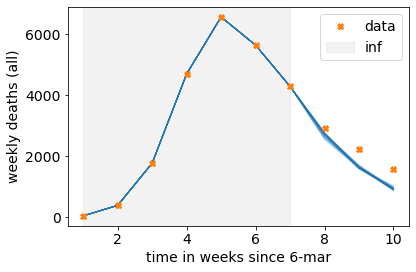

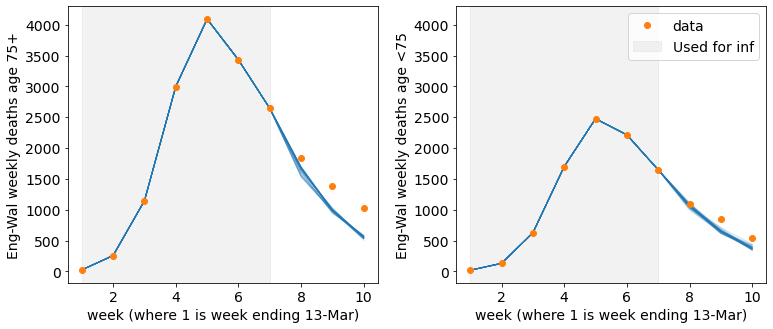

In [15]:
runTime = simTime + exptParams['forecastTime']
tVals = np.linspace(1,runTime,runTime)

indClass = model_spec['classes'].index('Im')
tValsMAP = np.linspace(1,simTime,simTime)
totClass = N*np.sum(trajMAP[:,indClass*numCohorts:(indClass+1)*numCohorts],axis=1)

totDeathObs = np.sum(deathCumulativeDat[:,:(runTime+1)],axis=0)

tValsFore = np.linspace(1+simTime,runTime,exptParams['forecastTime'])
tValsAll = np.append(tValsMAP,tValsFore)

for dataStoch in trajStoch :
        totClassStoch = np.sum(dataStoch[:,indClass*numCohorts:(indClass+1)*numCohorts],axis=1)
        trajAll = np.append(totDeathObs[:simTime],totClassStoch)
        plt.plot( tValsAll,diffs(trajAll),'-',lw=1,label=None,ms=4,color='C0',alpha=0.2)
        if False : print(diffs(trajAll)[-3])

plt.plot( tValsAll,diffs(np.sum(deathCumulativeDat[:,:(runTime+1)],axis=0)),'X',label='data',color='C1')

plt.ylabel('weekly deaths (all)')
plt.xlabel('time in weeks since 6-mar')
plt.axvspan(1, simTime,alpha=0.2, color='silver',label='inf')
plt.legend()
#plt.savefig(figPath+'foreStochAll.png')

plt.show() ; plt.close()

# TWO panels (with age)
fig,axs = plt.subplots(1,2,figsize=(11,4.8),sharey=True)
plt.subplots_adjust(wspace=0.3)

ax=axs[0]

for dataStoch in trajStoch :
        totClassStoch = dataStoch[:,-1+(indClass+1)*numCohorts]
        trajAll = np.append(deathCumulativeDat[-1,:simTime],totClassStoch)
        ax.plot( tValsAll,diffs(trajAll),'-',lw=1,label=None,ms=4,color='C0',alpha=0.2)
        if False : print(diffs(trajAll)[-3])

dObs = deathCumulativeDat[numCohorts-1,:runTime+1]
ax.plot(tVals,diffs(dObs), 'o', label='data' , color='C1' )
ax.set_ylabel('Eng-Wal weekly deaths age 75+')
ax.set_xlabel('week (where 1 is week ending 13-Mar)')
ax.axvspan(1, simTime,alpha=0.2, color='silver',
           label='Used for inf')

ax=axs[1]

for dataStoch in trajStoch :
        totClassStoch = np.sum(dataStoch[:,indClass*numCohorts:-1+(indClass+1)*numCohorts],axis=1)
        trajAll = np.append(np.sum(deathCumulativeDat[:-1,:simTime],axis=0),totClassStoch)
        plt.plot( tValsAll,diffs(trajAll),'-',lw=1,label=None,ms=4,color='C0',alpha=0.2)
        if False : print(diffs(trajAll)[-3])

dObs = np.sum(deathCumulativeDat[0:numCohorts-1,:runTime+1].transpose(), axis=1)
ax.plot(tVals,diffs(dObs), 'o', label='data' ,color='C1' )
            
ax.set_ylabel('Eng-Wal weekly deaths age <75')
ax.set_xlabel('week (where 1 is week ending 13-Mar)')
ax.tick_params(labelleft=True)
ax.axvspan(1, simTime,alpha=0.2, color='silver',
           label='Used for inf')
ax.legend()

#plt.savefig('foreStochTwoAge.png')
plt.show(fig) 

### stochastic forecast from full posterior conditional  distribution (uses van Kampen / CLT)

In [16]:
if doPostForecast :
    
    nStoch = 40
    trajStochPost = []  
    trajDetPost = []  
    paramPost = []
    if runStoch :

        if forceTauLeap : useNC = 0   ## always use tau-leaping (can cause problems if occupancies are low)
        else :            useNC = 30  ## default
        
        elapsedS = time.time() 
        
        ### PARALLEL
        def multiFuncPostSample(ii) :
            ## this is the sample to be considered (taken from END of mcmc results)
            rr = result_mcmc[-ii]
            
            estimator.set_params(rr['params_dict'])
            CM_post = contactBasis.intervention_custom_temporal( interventionFn, 
                                                                **rr['control_params_dict'] )
            estimator.set_contact_matrix( CM_post )

            sampleTime = simTime
            nSamp = 1  ## one endpoint sample per posterior sample
            samplesPost = estimator.sample_endpoints(obsDeath, fltrDeath, 
                                                     sampleTime, rr, 
                                                     nSamp, CM_post)
            
            ## this sorts out the intervention so that the sim starts at simTime
            offT = simTime
            def CM_offset(t) : return CM_post(t+offT)

            ss = 0 ## there is only one endpoint sample, this is the index for it

            stochModel = pyross.stochastic.Spp(model_spec, paramMap(rr['params_dict']), numCohorts, Ni)

            ICint = np.array(samplesPost[ss]*N).astype(int)
            simStoch = stochModel.simulate(ICint, CM_offset, 
                                           exptParams['forecastTime'], 
                                           1+exptParams['forecastTime'], 
                                           method='tau_leaping',
                                           nc=useNC)

            if nStoch < 8 or ii % int(nStoch/8) == 0 :
                 print('runPost {s:d} finished, of {n:d}'.format(s=ii,n=nStoch))

            return simStoch['X'] 

        
        pool = multiprocessing.Pool()
        trajStochPost = pool.map( multiFuncPostSample, list(range(nStoch)) )
        pool.close()  ## prevents further submission to pool
        pool.join()   ## waits for pool to terminate (not necessary because map(...) is blocking)

        elapsedS = time.time() - elapsedS
        print('elapsed',elapsedS/60,'mins')
        
        opFile = pikFileRoot + "-sample-post.pik"
        print('opf',opFile)
        with open(opFile, 'wb') as f: 
            pickle.dump([trajStochPost],f)
        
else:
    ipFile = pikFileRoot + "-sample-post.pik"
    print('ipf',ipFile)
    with open(ipFile, 'rb') as f: 
        [trajStochPost] = pickle.load(f)

ipf ewMod-sample-post.pik


#### plot results

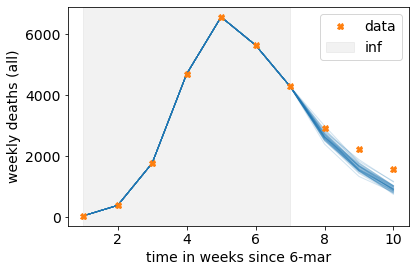

In [17]:
indClass = model_spec['classes'].index('Im')
tValsMAP = np.linspace(1,simTime,simTime)
totClass = N*np.sum(trajMAP[:,indClass*numCohorts:(indClass+1)*numCohorts],axis=1)

totDeathObs = np.sum(deathCumulativeDat[:,:(runTime+1)],axis=0)

tValsFore = np.linspace(1+simTime,runTime,exptParams['forecastTime'])
tValsAll = np.append(tValsMAP,tValsFore)

for dataStoch in trajStochPost :
        totClassStoch = np.sum(dataStoch[:,indClass*numCohorts:(indClass+1)*numCohorts],axis=1)
        trajAll = np.append(totDeathObs[:simTime],totClassStoch)
        plt.plot( tValsAll,diffs(trajAll),'-',lw=1,label=None,ms=4,color='C0',alpha=0.2)
        if False : print(diffs(trajAll)[-3])

plt.plot( tValsAll,diffs(np.sum(deathCumulativeDat[:,:(runTime+1)],axis=0)),'X',label='data',color='C1')

plt.ylabel('weekly deaths (all)')
plt.xlabel('time in weeks since 6-mar')
plt.axvspan(1, simTime,alpha=0.2, color='silver',label='inf')
plt.legend()
#plt.savefig(figPath+'foreStochAll.png')

plt.show() ; plt.close()